<a href="https://colab.research.google.com/github/KK-marius/Project-NLP-bag-of-words/blob/main/Text_classification_with_RNN_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Neural Networks

## Imports & Usefull Tools

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 971.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import shutil

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([f'train {metric}', f'validation {metric}'])
  plt.grid()

def fit_and_test(model, train_dataset, validation_dataset, epochs):
  history = model.fit(train_dataset, epochs=epochs,
                      validation_data=validation_dataset,
                      #validation_steps=10
                      )

  validation_loss, validation_acc = model.evaluate(validation_dataset)

  print('Validation Loss:', validation_loss)
  print('Validation Accuracy:', validation_acc)

  sample_text = [
    'This is a proper sentence.',
    'These is an less proper sentences.',
    '.sentence bad a is This'
  ]
  predictions = tf.sigmoid(model.predict(tf.constant(sample_text)))
  for text, pred in zip(sample_text, predictions):
    print(f"{text:10} >> {pred}")

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

# fit_and_test(model, train_dataset, validation_dataset, epochs=2)

## Data

In [ ]:
dataset, info = tfds.load('glue/cola', with_info=True)
original_train_dataset, original_validation_dataset, original_test_dataset = dataset['train'], dataset['validation'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/incomplete.VDIMVU_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/incomplete.VDIMVU_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/incomplete.VDIMVU_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(original_train_dataset.element_spec)
for ex in original_train_dataset.take(1):
  print(type(ex))
  print(ex.keys())
  print('texts: ', ex['sentence'].numpy())
  print('labels: ', ex['label'].numpy())

{'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}
<class 'dict'>
dict_keys(['idx', 'label', 'sentence'])
texts:  b'It is this hat that it is certain that he was wearing.'
labels:  1


In [ ]:
BUFFER_SIZE = 500
BATCH_SIZE = 64

train_dataset = original_train_dataset.map(lambda ex: (ex['sentence'], ex['label'])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = original_validation_dataset.map(lambda ex: (ex['sentence'], ex['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = original_test_dataset.map(lambda ex: (ex['sentence'], ex['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"That Bill's breath smells of onions bothers Erin."
 b'The eggs and the cream mixed together.'
 b"Any student in Mary's class happened to vote."]

labels:  [1 1 0]


### Question
> What's the impact of `map(lambda ex: (ex['sentence'], ex['label']))` in previous cell?

**R :** map(lambda ex: (ex['sentence'], ex['label'])) associe à chaque phrase un label. Cette action est appliquée sur tout le jeu de données.

## Classification with a Bi-LSTM

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'that', 'i', 'is', 'john', 'of',
       'and', 'was', 'in', 'he', 'you', 'it', 'be', 'who', 'mary', 'on'],
      dtype='<U12')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  5, 646,   1,   1,   9,   1, 897,   1,   0,   0,   0,   0,   0,
          0,   0],
       [  2, 799,  10,   2, 277, 670, 429,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 53,  74,  12, 356, 249, 517,   3,   1,   0,   0,   0,   0,   0,
          0,   0]])

### Question
> One may reconstruct a text from its encoded version (see the example below). What are the differences between the original text and the reconstructed one?

**R :** Le texte reconstruit peut différer de l'original en raison de la perte d'informations, des artefacts de tokenisation, de la normalisation de la casse, des ambiguïtés, du bruit, des changements de formatage ou de la perte contextuelle, en fonction du processus d'encodage et de décodage.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"That Bill's breath smells of onions bothers Erin."
Round-trip:  that bills [UNK] [UNK] of [UNK] bothers [UNK]       

Original:  b'The eggs and the cream mixed together.'
Round-trip:  the eggs and the cream mixed together        

Original:  b"Any student in Mary's class happened to vote."
Round-trip:  any student in marys class happened to [UNK]       



### Question

> What means the argument `from_logits=True` of the function `compile()` below?

**R :** L'argument from_logits=True dans la fonction compile() indique que la sortie du modèle est constituée de logits (scores non normalisés) plutôt que de probabilités. La fonction de perte (par exemple, SparseCategoricalCrossentropy) appliquera alors un softmax ou sigmoid en interne pour convertir les logits en probabilités avant de calculer la perte.

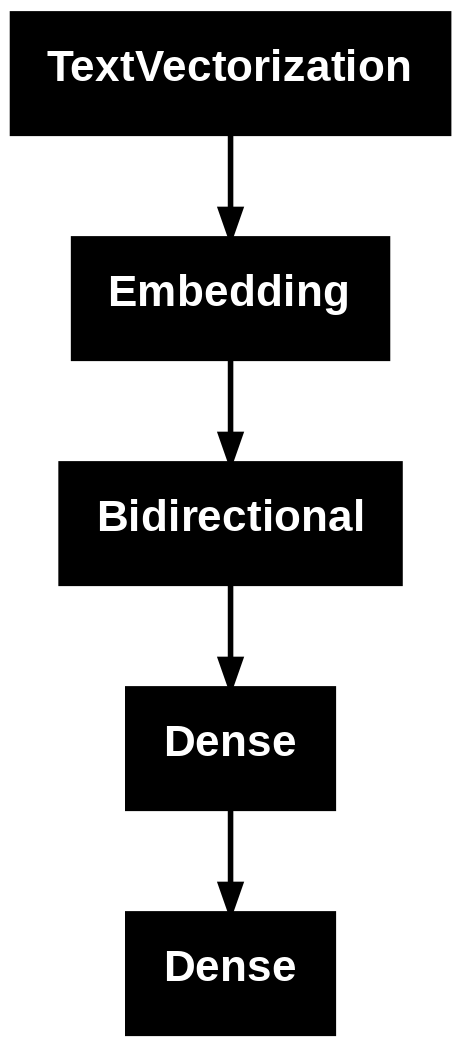

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.build()
tf.keras.utils.plot_model(model)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.3162 - loss: 0.6706 - val_accuracy: 0.6414 - val_loss: 0.6155
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6517 - loss: 0.6002 - val_accuracy: 0.6625 - val_loss: 0.6132
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6792 - loss: 0.5972 - val_accuracy: 0.6683 - val_loss: 0.6107
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6953 - loss: 0.5924 - val_accuracy: 0.6721 - val_loss: 0.6090
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7081 - loss: 0.5857 - val_accuracy: 0.6759 - val_loss: 0.6073
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7201 - loss: 0.5763 - val_accuracy: 0.6702 - val_loss: 0.6052
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7207 - loss: 0.5652 - val_accuracy: 0.6539 - val_loss: 0.6054
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7149 - loss: 0.5515 - val_a

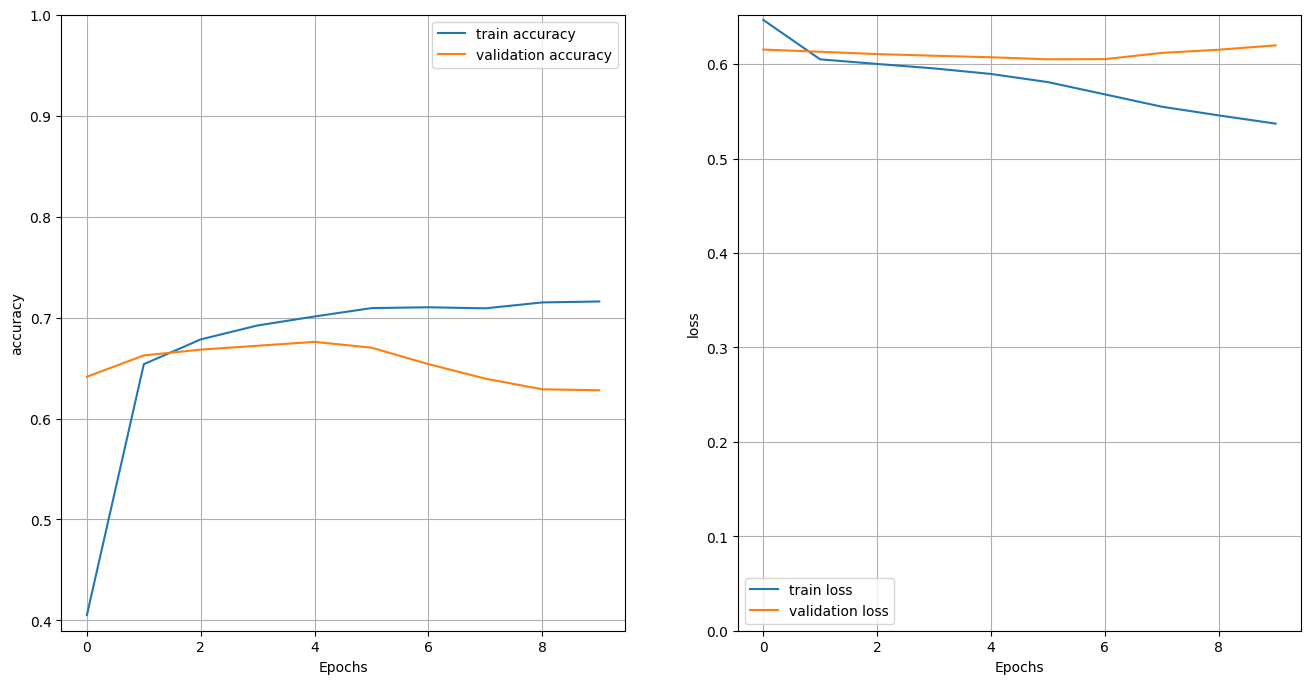

In [ ]:
fit_and_test(model, train_dataset, validation_dataset, epochs=10)

### Question

> When would you stop the iterations of the gradient descent above? Why?

**R :** On arrête les itérations de la descente de gradient lorsque la perte converge vers un minimum (cesse de diminuer significativement) ou après un nombre prédéfini d'époques. Cela évite le surapprentissage et des calculs inutiles.

In [ ]:
examples = [
    'This is a proper sentence.',
    'These is an less proper sentences.',
    '.sentence bad a is This'
]

predictions = tf.sigmoid(model(tf.constant(examples)))

for text, pred in zip(examples, predictions):
  print(f'input: {text:<30} : score: {pred[0]:.6f}')

input: This is a proper sentence.     : score: 0.826427
input: These is an less proper sentences. : score: 0.949692
input: .sentence bad a is This        : score: 0.771338


## Classification with BERT

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=False)

bert_results = bert_model(bert_preprocess_model(text_test))

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999945   0.14341968 -0.998978    0.9951449  -0.9997457   0.9131292
 -0.9961582  -0.9709752   0.0974001   0.01907069 -0.8488175  -0.09385536]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.4372365  -1.0138301  -2.374475   ... -0.7589705  -2.0910313
  -0.25809926]
 [-1.3369718  -0.36880213  0.57868755 ... -2.1810164  -1.7530917
  -0.09555079]
 [-1.0607058  -0.30370995  0.34461257 ... -1.2898587  -1.9519889
  -0.12230287]
 ...
 [-0.860227   -0.54406184  0.6583737  ... -1.4765681  -1.7518607
   1.1197375 ]
 [-0.4686899  -0.57152385  0.6725658  ... -1.730234   -1.9740782
   0.9747929 ]
 [ 0.0203663  -0.7551188   0.59482384 ... -1.9656774  -1.9051418
   0.48970175]]


In [ ]:
class MyBert(tf.keras.Model):
    def __init__(self):
        super(MyBert, self).__init__()
        self.last = tf.keras.layers.Dense(1)

    def call(self, inputs):
      encoder_inputs = bert_preprocess_model(inputs)
      outputs = bert_model(encoder_inputs)
      return self.last(outputs['pooled_output'])

model = MyBert()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model.build()
#tf.keras.utils.plot_model(model)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.4895 - loss: 0.6353 - val_accuracy: 0.6357 - val_loss: 0.6286
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6558 - loss: 0.6139 - val_accuracy: 0.6520 - val_loss: 0.6283
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 87s 407ms/step - accuracy: 0.6685 - loss: 0.6130 - val_accuracy: 0.6539 - val_loss: 0.6280
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 373ms/step - accuracy: 0.6667 - loss: 0.6139 - val_accuracy: 0.6548 - val_loss: 0.6276
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 374ms/step - accuracy: 0.6692 - loss: 0.6123 - val_accuracy: 0.6587 - val_loss: 0.6272
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.6664 - loss: 0.6154
Validation Loss: 0.6272234916687012
Validation Accuracy: 0.6586769223213196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
This is a proper sentence. >> [0.73587877]
These is an less proper sentences. >> [0.7827404]
.sentence bad a is This >> [0.7055586]


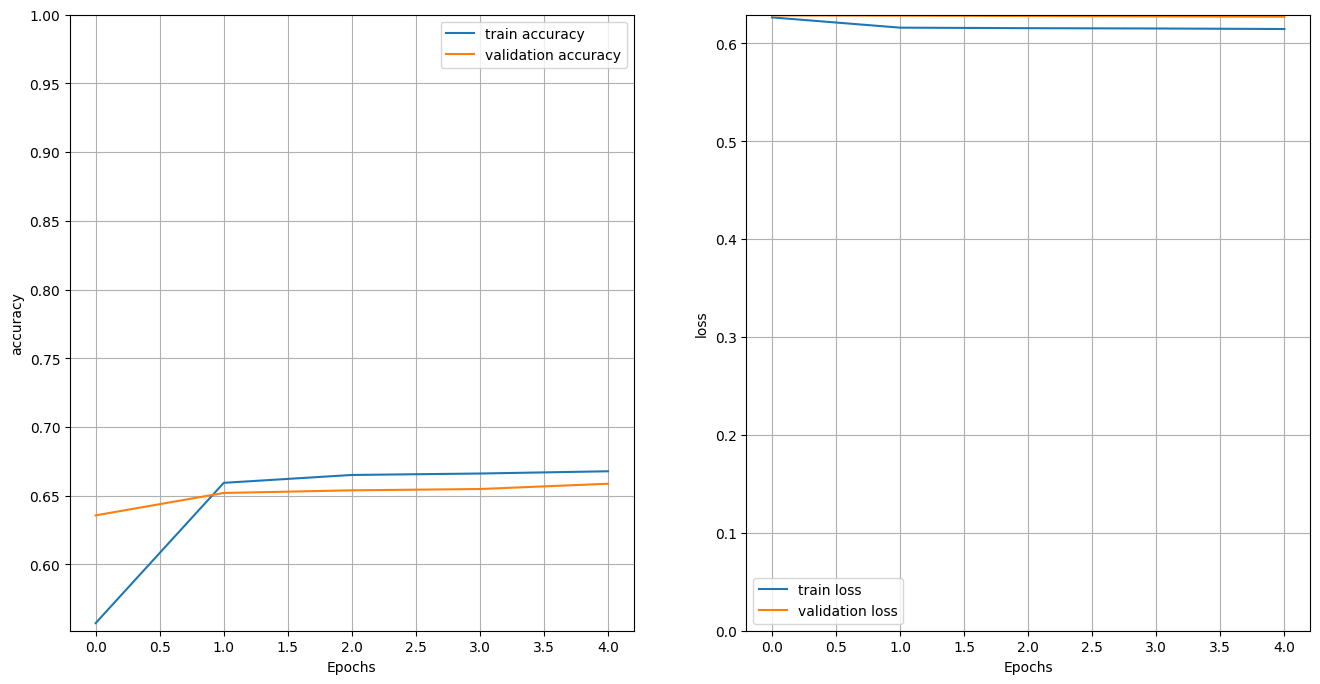

In [ ]:
fit_and_test(model, train_dataset, validation_dataset, epochs=5)

### Question
> Comment these curves

**R :** La précision augmente à la fois pour l'entraînement et la validation, ce qui indique que le modèle apprend correctement. La perte diminue progressivement, ce qui est un signe positif d'amélioration des performances. Les courbes d'entraînement et de validation restent proches, ce qui montre un bon équilibre sans surapprentissage. En résumé, le modèle apprend efficacement avec de bonnes performances sur les données d'entraînement et de validation.

In [ ]:
examples = [
    'This is a proper sentence.',
    'These is an less proper sentences.',
    '.sentence bad a is This'
]

predictions = tf.sigmoid(model(tf.constant(examples)))

for text, pred in zip(examples, predictions):
  print(f'input: {text:<30} : score: {pred[0]:.6f}')

input: This is a proper sentence.     : score: 0.735879
input: These is an less proper sentences. : score: 0.782740
input: .sentence bad a is This        : score: 0.705559


## Short version

### Question

> add below a version of the codes limited to the code required to
> * load the data
> * build the model, train the model, and display the learning curves and the final validation loss and accuracy

In [ ]:
# load the data
dataset = tfds.load('glue/cola')
original_train_dataset, original_validation_dataset, original_test_dataset = dataset['train'], dataset['validation'], dataset['test']

BUFFER_SIZE = 500
BATCH_SIZE = 64

train_dataset = original_train_dataset.map(lambda ex: (ex['sentence'], ex['label'])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = original_validation_dataset.map(lambda ex: (ex['sentence'], ex['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = original_test_dataset.map(lambda ex: (ex['sentence'], ex['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.3055 - loss: 0.6766 - val_accuracy: 0.6366 - val_loss: 0.6192
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6390 - loss: 0.6041 - val_accuracy: 0.6548 - val_loss: 0.6141
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6783 - loss: 0.5972 - val_accuracy: 0.6769 - val_loss: 0.6120
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6914 - loss: 0.5943 - val_accuracy: 0.6798 - val_loss: 0.6102
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.7056 - loss: 0.5868 - val_accuracy: 0.6788 - val_loss: 0.6067


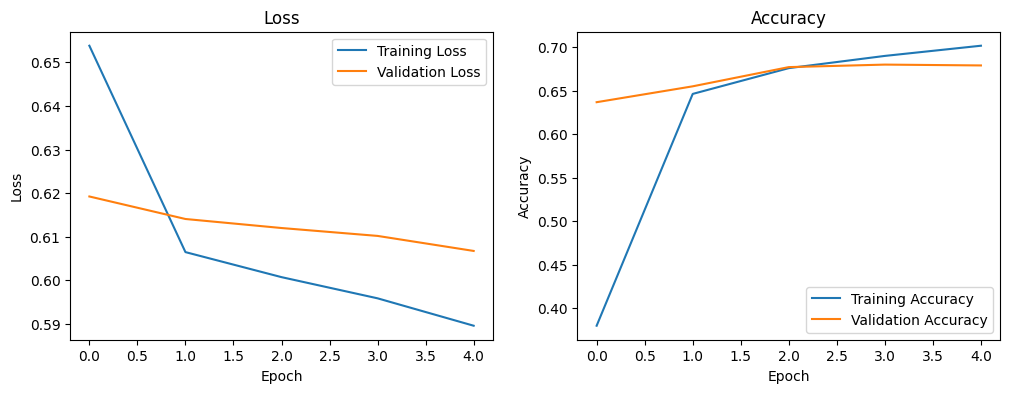

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6657 - loss: 0.6082
Validation Loss: 0.6067423820495605
Validation Accuracy: 0.6788111329078674


In [ ]:
# build the model, train the model, and display the learning curves and the final validation loss and accuracy

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=False)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Train the model
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=5)

# Plot learning curves
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_learning_curves(history)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


## You own model

### Question
> Implement one of the following idea and comment its results:
> * Stack several BiLSTM. It requires the "hidden" Bi-LSTM to output one tensor per input token, whihc is obtained with the parameter `return_sequences=True`
> * Add a BiLSTM on-top of Bert. This BiLSTM has to use the output of the LSTM which corresponds to a tensor per input token (see `['sequence_output']`).


Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.2932 - loss: 3.0865 - val_accuracy: 0.3087 - val_loss: 1.8756
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.2887 - loss: 1.7888 - val_accuracy: 0.3087 - val_loss: 1.3109
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.2978 - loss: 1.2286 - val_accuracy: 0.4219 - val_loss: 0.9334
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.4164 - loss: 0.9220 - val_accuracy: 0.4813 - val_loss: 0.9097
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4739 - loss: 0.8496 - val_accuracy: 0.5053 - val_loss: 0.8612


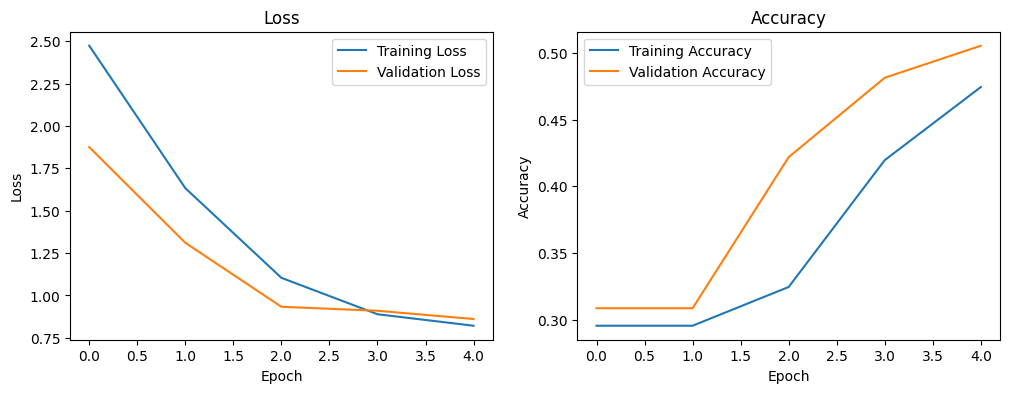

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4882 - loss: 0.8500
Validation Loss: 0.8611904978752136
Validation Accuracy: 0.5052732229232788


In [ ]:
# R : Stack several BiLSTM

from tensorflow.keras import layers

model1 = tf.keras.Sequential([
    encoder,
    layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True),
    layers.Bidirectional(layers.LSTM(60, return_sequences=True)),  # First BiLSTM layer
    layers.Bidirectional(layers.LSTM(16)),  # Final BiLSTM layer (no return_sequences)
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for binary classification
])

# Compile the model
model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


# Train the model
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=5)

plot_learning_curves(history)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model1.evaluate(validation_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')